# CS421: Introduction to Machine Learning
## Project: Predicting Credit Card Customer Churn
### Model: Random Forest
---

# 1. Importing packages and libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import make_scorer, recall_score, fbeta_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix

# 2. Reading file and tidying up columns

In [2]:
environment = 'local' # change this

if environment == 'local':
    df_train = pd.read_csv("../data/train.csv")
    df_test = pd.read_csv("../data/test.csv")
elif enviroment == 'kaggle':
    df_train = pd.read_csv("./train.csv")
    df_test = pd.read_csv("./test.csv")

y_train = df_train[["attrition_flag"]]
x_train = df_train.drop("attrition_flag", axis=1)

y_test = df_test[["attrition_flag"]]
x_test = df_test.drop("attrition_flag", axis=1)

# 3. Model Performance before Hyperparameter tuning

In [3]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer

def cv_evaluate_model(rf_clf):
    smote_sampler = SMOTE(random_state=2021)

    scale_features = x_train.columns[1:]

    scaler = ColumnTransformer(transformers=[ ('scaler', MinMaxScaler(), scale_features) ])

    pipeline = Pipeline(steps = [['scaler', scaler],
                                 ['smote', smote_sampler],
                                 ['classifier', rf_clf]])

    stratified_kfold = StratifiedKFold(shuffle=True, n_splits=5, random_state=2021)

    scoring = {"recall": 'recall',
               "fbeta_2": make_scorer(fbeta_score, beta=2),
               "roc_auc": make_scorer(roc_auc_score),
              }

    scores = cross_validate(pipeline, x_train, y_train.values.ravel(), cv=stratified_kfold,
                           scoring = scoring)

    recall = [ val for val in scores['test_recall'] ]
    fbeta_2 = [ val for val in scores['test_fbeta_2'] ]
    auc = [ val for val in scores['test_roc_auc'] ]
    recall.append( sum(recall) / len(recall) )
    fbeta_2.append( sum(fbeta_2) / len(fbeta_2) )
    auc.append( sum(auc) / len(auc) )

    score_df = pd.DataFrame(data=[recall, fbeta_2, auc], columns=['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5', 'Average'],
                            index=['Recall','Fbeta2','AUC'])
    return score_df

In [26]:
base_rf_clf = RandomForestClassifier(random_state=2021)

results = cv_evaluate_model(base_rf_clf)
display(results_base)

results_base = results['Average'] # retrieve performance

Recall    0.834845
Fbeta2    0.828026
AUC       0.897714
Name: Average, dtype: float64

# 4. Hyper parameter tuning with GridSearchCV

## 4.1 First GridSearchCV

In [5]:
# Creating parameter grid to search
n_estimators = [100, 300, 500, 700, 900]

max_features = ['sqrt', 'log2']

max_depth = [5, 10, 15, 20]

min_samples_split = [3, 5, 8, 10, 13]

min_samples_leaf = [1, 3, 5, 8, 10]

params_grid = {
                'classifier__n_estimators': n_estimators,
                'classifier__max_features': max_features,
                'classifier__min_samples_split': min_samples_split,
                'classifier__min_samples_leaf': min_samples_leaf,
                'classifier__max_depth': max_depth
              }

total_combi = 1
for param, value in params_grid.items():
    print(param, value)
    total_combi *= len(value)

print('-----------------')
print('Total combinations:', total_combi)
print('Across 5-folds =',total_combi*5)

classifier__n_estimators [100, 300, 500, 700, 900]
classifier__max_features ['sqrt', 'log2']
classifier__min_samples_split [3, 5, 8, 10, 13]
classifier__min_samples_leaf [1, 3, 5, 8, 10]
classifier__max_depth [5, 10, 15, 20]
-----------------
Total combinations: 1000
Across 5-folds = 5000


In [6]:
# # running grid search 1
# smote_sampler = SMOTE(random_state=2021)
# rf_clf = RandomForestClassifier(random_state=2021)

# scale_features = x_train.columns[1:]

# scaler = ColumnTransformer(transformers=[ ('scaler', MinMaxScaler(), scale_features) ])

# pipeline = Pipeline(steps = [['scaler', scaler],
#                              ['smote', smote_sampler],
#                              ['classifier', rf_clf]])

# stratified_kfold = StratifiedKFold(shuffle=True, n_splits=5, random_state=2021)

# rf_gridsearch = GridSearchCV(estimator = pipeline,
#                            param_grid = params_grid,
#                            scoring = 'recall',
#                            cv = stratified_kfold,
#                            refit = True,
#                            n_jobs = -1)

# rf_gridsearch.fit(x_train, y_train.values.ravel() )

# best_parameters = rf_gridsearch.best_params_
# print(best_parameters)

{'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 8, 'classifier__min_samples_split': 3, 'classifier__n_estimators': 100}

In [25]:
# classifier trained on the latest hyper parameters
gs_clf1 = RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=8,
                                min_samples_split=3, n_estimators=100,
                                random_state=2021)

results = cv_evaluate_model(gs_clf1)
display(results)

results_gs1 = results['Average'] # retrieve results

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Average
Recall,0.869732,0.869231,0.838462,0.853846,0.888889,0.864032
Fbeta2,0.850187,0.835799,0.817091,0.822832,0.856089,0.836400
AUC,0.911336,0.902998,0.891290,0.894938,0.915379,0.903188


## 4.2 Second GridSearchCV
This second parameter search space aims to narrow down the search space based on the results obtained in the first grid search.

**Previous parameter search space:**
- n_estimators [100, 300, 500, 700, 900]
- max_features ['sqrt', 'log2']
- min_samples_split [3, 5, 8, 10, 13]
- min_samples_leaf [1, 3, 5, 8, 10]
- max_depth [5, 10, 15, 20]

**Obtained results:**

| Feature           | Value | New search space |
|-------------------|:-----:|------------|
| n_estimators      | 100   | [50, 75, 100, 125, 150] |
| max_features      |'sqrt' | Leave as sqrt |
| min_samples_split | 3     | [2, 3, 4] |
| min_samples_leaf  | 8     | [6, 7, 8, 9] |
| max_depth         | 10    | [8, 9, 10, 11, 12] |


In [8]:
# Creating parameter grid to search
n_estimators = [50, 75, 100, 125, 150]

min_samples_split = [2, 3, 4]

min_samples_leaf = [6, 7, 8, 9, 10]

max_depth = [8, 9, 10, 11, 12]

params_grid = {
                'classifier__n_estimators': n_estimators,
                'classifier__min_samples_split': min_samples_split,
                'classifier__min_samples_leaf': min_samples_leaf,
                'classifier__max_depth': max_depth
              }

total_combi = 1
for param, value in params_grid.items():
    print(param, value)
    total_combi *= len(value)

print('-----------------')
print('Total combinations:', total_combi)
print('Across 5-folds =',total_combi*5)

classifier__n_estimators [50, 75, 100, 125, 150]
classifier__min_samples_split [2, 3, 4]
classifier__min_samples_leaf [6, 7, 8, 9, 10]
classifier__max_depth [8, 9, 10, 11, 12]
-----------------
Total combinations: 375
Across 5-folds = 1875


In [9]:
# # running grid search 2
# smote_sampler = SMOTE(random_state=2021)
# rf_clf = RandomForestClassifier(max_features='sqrt', random_state=2021)

# scale_features = x_train.columns[1:]

# scaler = ColumnTransformer(transformers=[ ('scaler', MinMaxScaler(), scale_features) ])

# pipeline = Pipeline(steps = [['scaler', scaler],
#                              ['smote', smote_sampler],
#                              ['classifier', rf_clf]])

# stratified_kfold = StratifiedKFold(shuffle=True, n_splits=5, random_state=2021)

# rf_gridsearch = GridSearchCV(estimator = pipeline,
#                            param_grid = params_grid,
#                            scoring = 'recall',
#                            cv = stratified_kfold,
#                            refit = True,
#                            n_jobs = -1)

# rf_gridsearch.fit(x_train, y_train.values.ravel() )

# best_parameters = rf_gridsearch.best_params_
# print(best_parameters)

{'classifier__max_depth': 10, 'classifier__min_samples_leaf': 8, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 125}

In [37]:
rf_clf2 = RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=8,
                                min_samples_split=2, n_estimators=125,
                                random_state=2021)

results = cv_evaluate_model(rf_clf2)
display(results)

results_gs2 = results['Average'] # retrieve performance

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Average
Recall,0.873563,0.869231,0.834615,0.861538,0.888889,0.865567
Fbeta2,0.852655,0.835799,0.814565,0.829016,0.857988,0.838004
AUC,0.912885,0.902998,0.889734,0.898784,0.916483,0.904177


## 4.3 Third GridSearchCV
This third parameter search space aims to narrow down the search space based on the results obtained in the first grid search.

**Previous parameter search spaces:**
1. GridSearch 1
- n_estimators = [100, 300, 500, 700, 900]
- max_features = ['sqrt', 'log2']
- min_samples_split = [3, 5, 8, 10, 13]
- min_samples_leaf = [1, 3, 5, 8, 10]
- max_depth = [5, 10, 15, 20]

2. GridSearch 2
- n_estimators = [50, 75, 100, 125, 150]
- min_samples_split = [2, 3, 4]
- min_samples_leaf = [6, 7, 8, 9, 10]
- max_depth = [8, 9, 10, 11, 12]

**Obtained results:**

| Feature           | GridSearch1 | GridSearch2 |      New search space     |
|-------------------|:-----------:|:-----------:|:-------------------------:|
| n_estimators      |     100     |     125     | [100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150] |
| min_samples_split |      3      |      2      |         [2,3]           |
| min_samples_leaf  |      8      |      8      |         Leave as 8        |
|    max_depth      |     10      |     10      |         Leave as 10       |



In [11]:
# Creating parameter grid to search
n_estimators = [100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150]
min_samples_split = [2, 3]

params_grid = {
                'classifier__n_estimators': n_estimators,
                'classifier__min_samples_split': min_samples_split
              }

total_combi = 1
for param, value in params_grid.items():
    print(param, value)
    total_combi *= len(value)

print('-----------------')
print('Total combinations:', total_combi)
print('Across 5-folds =',total_combi*5)

classifier__n_estimators [100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150]
classifier__min_samples_split [2, 3]
-----------------
Total combinations: 22
Across 5-folds = 110


In [12]:
# # running grid search 3
# smote_sampler = SMOTE(random_state=2021)
# rf_clf = RandomForestClassifier(min_samples_leaf=8, max_depth=10, max_features='sqrt', random_state=2021)

# scale_features = x_train.columns[1:]

# scaler = ColumnTransformer(transformers=[ ('scaler', MinMaxScaler(), scale_features) ])

# pipeline = Pipeline(steps = [['scaler', scaler],
#                              ['smote', smote_sampler],
#                              ['classifier', rf_clf]])

# stratified_kfold = StratifiedKFold(shuffle=True, n_splits=5, random_state=2021)

# rf_gridsearch = GridSearchCV(estimator = pipeline,
#                            param_grid = params_grid,
#                            scoring = 'recall',
#                            cv = stratified_kfold,
#                            refit = True,
#                            n_jobs = -1)

# rf_gridsearch.fit(x_train, y_train.values.ravel() )

# best_parameters = rf_gridsearch.best_params_
# print(best_parameters)

{'classifier__min_samples_split': 2, 'classifier__n_estimators': 105}

In [36]:
rf_clf3 = RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=8,
                                min_samples_split=2, n_estimators=105,
                                random_state=2021)

results = cv_evaluate_model(rf_clf3)
display(results)

results_gs3 = results['Average'] # retrieve performance

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Average
Recall,0.869732,0.869231,0.838462,0.861538,0.888889,0.865570
Fbeta2,0.850187,0.835181,0.817704,0.828402,0.857354,0.837766
AUC,0.911336,0.902630,0.891657,0.898416,0.916115,0.904031


## 4.4 Consolidating model improvements

In [54]:
results_dict = {
    "Base": results_base,
    "GridSearch1": results_gs1,
    "GridSearch2": results_gs2,
    "GridSearch3": results_gs3
}

overall_results = pd.DataFrame(results_dict).T
overall_results.index.name = 'Model'
overall_results.sort_values(by=['Recall','Fbeta2','AUC'], ascending=False)

,Recall,Fbeta2,AUC
Model,,,
GridSearch3,0.865570,0.837766,0.904031
GridSearch2,0.865567,0.838004,0.904177
GridSearch1,0.864032,0.836400,0.903188
Base,0.834845,0.828026,0.897714


### Conclusion:
- Parameters obtained from GridSearch2 would be used to create the final model.
- GridSearch2 performance on Recall is very marginal

# 4. Evaluation on Test

In [50]:
smote_sampler = SMOTE(random_state=2021)

rf_clf = RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=8,
                                min_samples_split=2, n_estimators=125,
                                random_state=2021)

scale_features = x_train.columns[1:]

scaler = ColumnTransformer(transformers=[ ('scaler', MinMaxScaler(), scale_features) ])

pipeline = Pipeline(steps = [['scaler', scaler],
                             ['smote', smote_sampler],
                             ['classifier', rf_clf]])

pipeline.fit(x_train, y_train.values.ravel() )

y_pred = pipeline.predict(x_test)

print("-----------------------PERFORMANCE EVALUATION--------------------  ")
print(f"Recall: {recall_score(y_test, y_pred)} ")
print(f"Fbeta2: {fbeta_score(y_test, y_pred, beta=2)} ")
print(f"AUC Score: {roc_auc_score(y_test, y_pred)} ")

-----------------------PERFORMANCE EVALUATION--------------------  
Recall: 0.8584615384615385 
Fbeta2: 0.8323389021479715 
AUC Score: 0.9007181296070186 


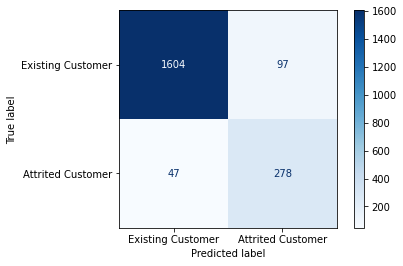

In [16]:
cm = confusion_matrix(y_test, y_pred)
labels = ['Existing Customer', 'Attrited Customer']

diagram = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
diagram.plot(cmap=plt.cm.Blues)
plt.show()